#**코랩에서 실행할 때 실행전 준비사항**
---
1. sample_data와 같은 위치에 data폴더 생성
2. data폴더에 데이터셋 ex)kor-copy 파일 업로드
3. prepareData함후 호출 전 필요한 데이터 셋의 이름을 설정

# **딥러닝 자동보정기 개발**
---
> - Sequence to Sequence (Encoder && Decoder)
> - GRU(Bidirectional) && Attention


# **Architecture**


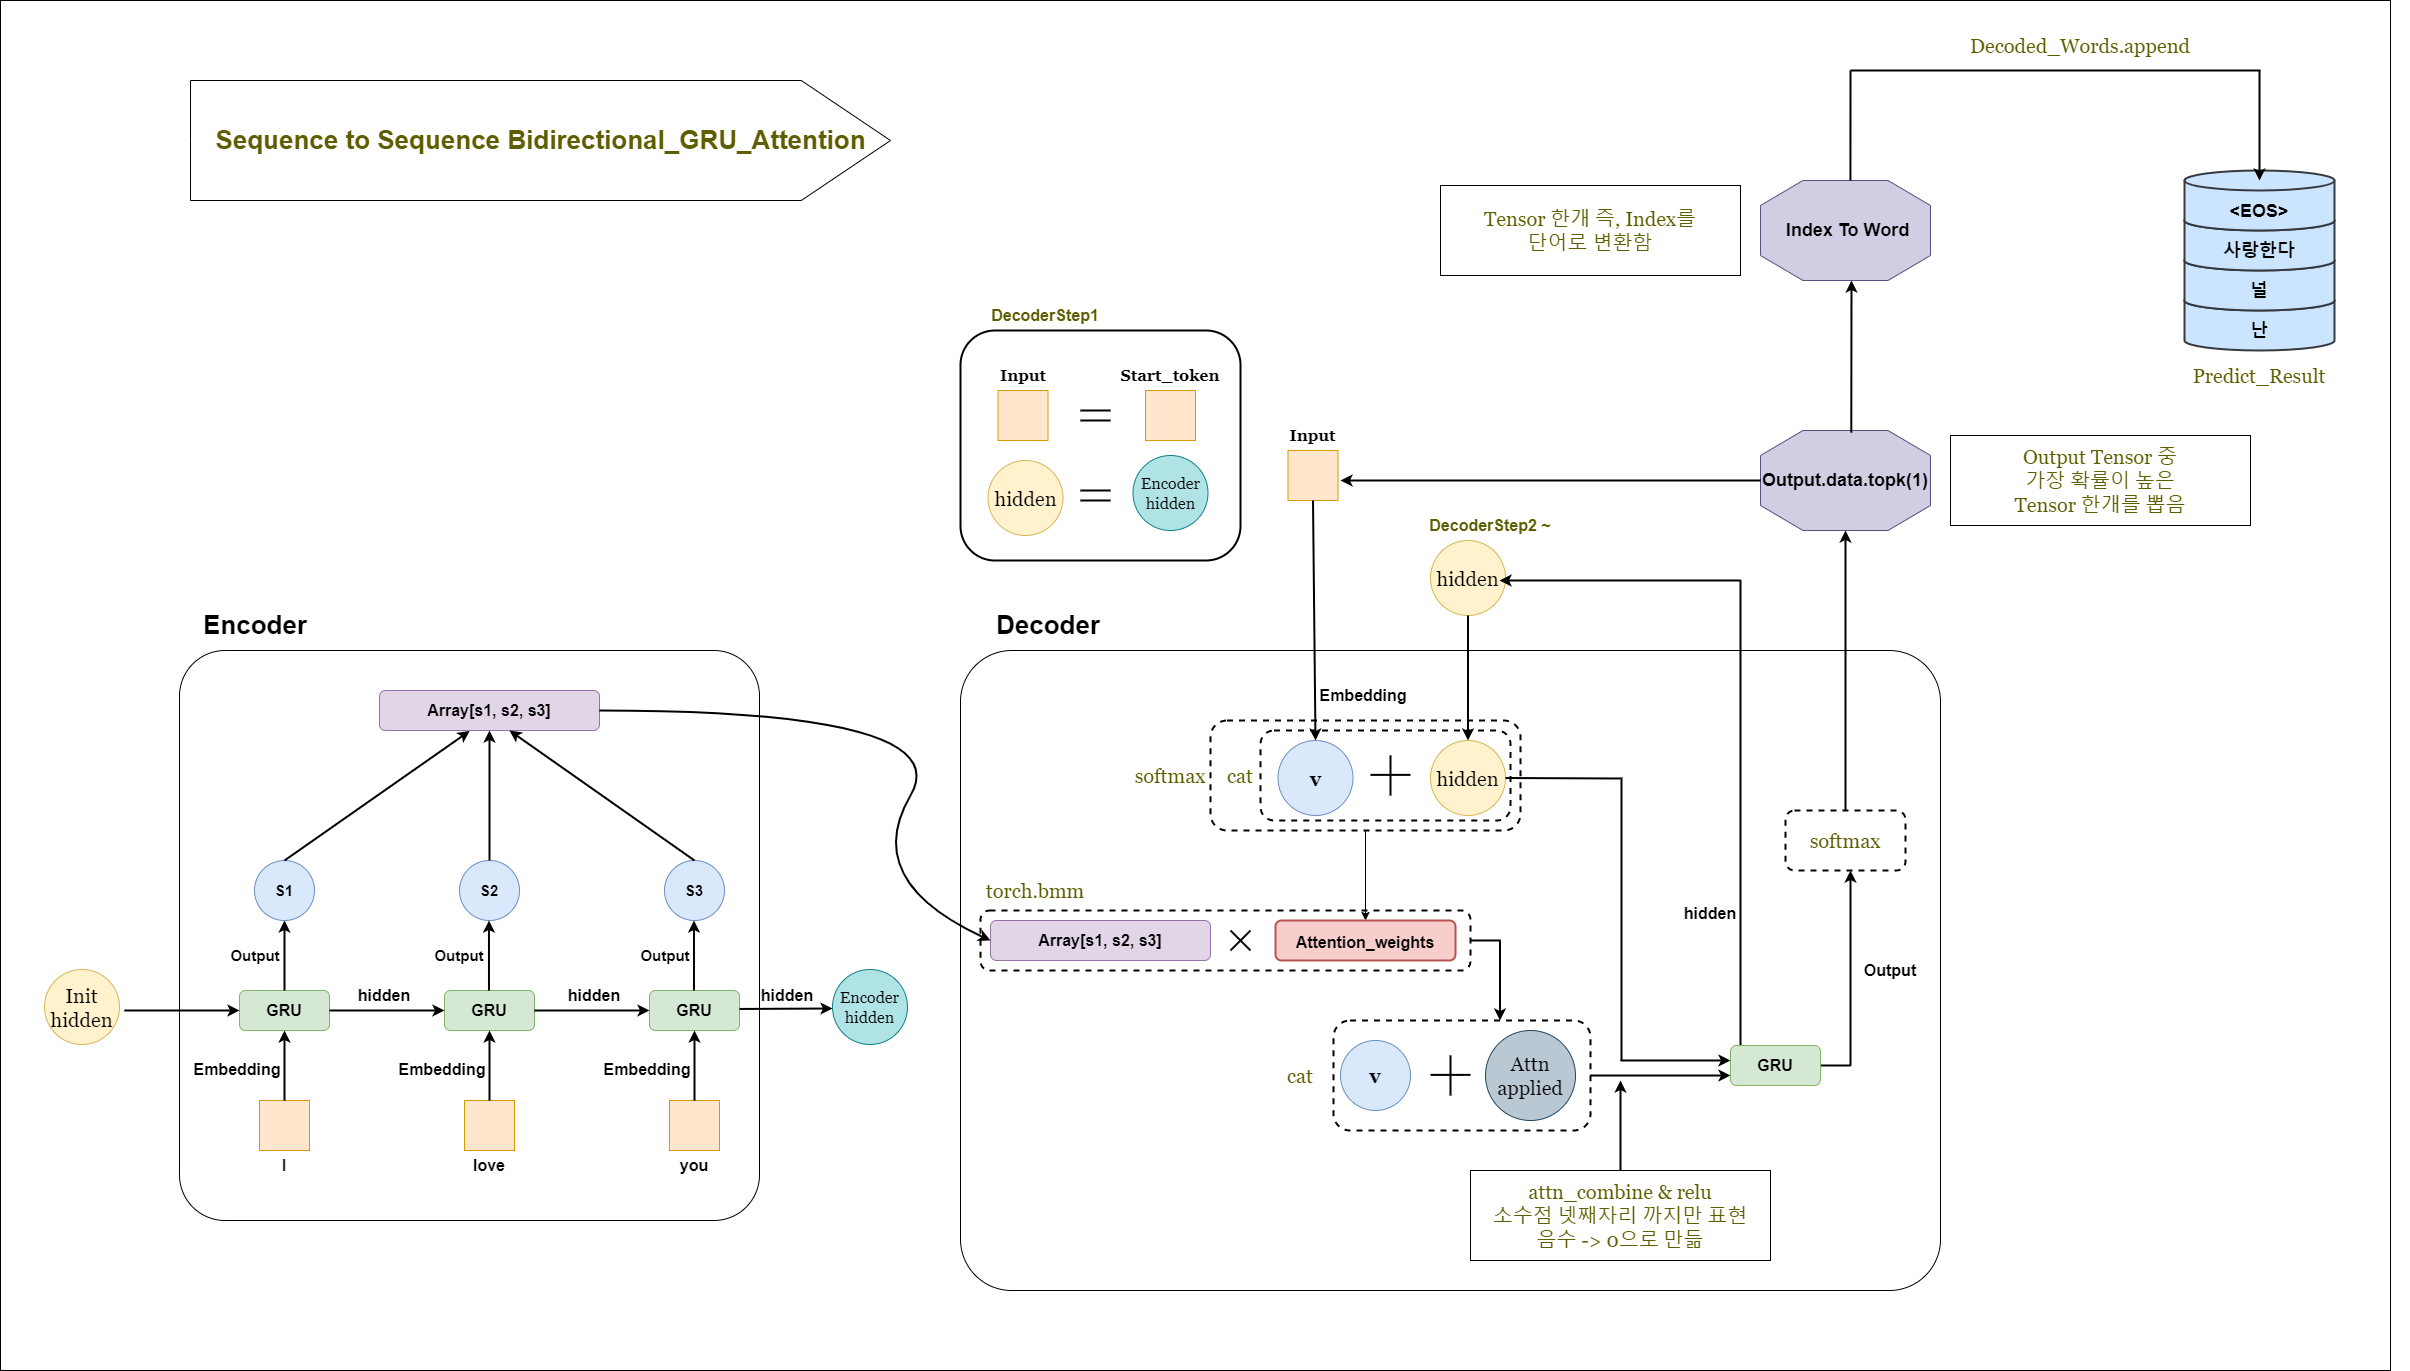

하나의 시퀀스를 다른 시퀀스로 바꾸는 두개의 RNN이 함께 동작하는
[sequence to sequence network](https://arxiv.org/abs/1409.3215) 의 간단하지만 강력한 아이디어가
이것(번역)을 가능하게 합니다. 인코더 네트워크는 입력 시퀀스를 벡터로 압축하고,
디코더 네트워크는 해당 벡터를 새로운 시퀀스로 펼칩니다.

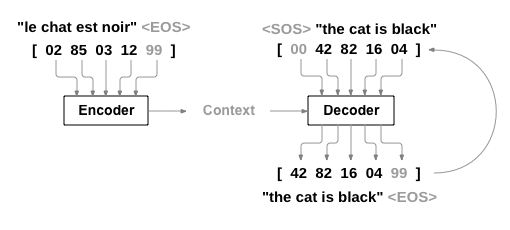

최소한 Pytorch를 설치했고, Python을 알고, Tensor를 이해한다고 가정합니다.:

- http://pytorch.org/ 설치 안내를 위한 자료

- [PyTorch로 딥러닝하기](https://tutorials.pytorch.kr/beginner/deep_learning_60min_blitz.html): 60분만에 끝장내기 일반적인 PyTorch 시작을 위한 자료

- [예제로 배우는 파이토치(PyTorch)](https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html) 넓고 깊은 통찰을 위한 자료

- [Torch 사용자를 위한 PyTorch](https://tutorials.pytorch.kr/beginner/former_torchies_tutorial.html) 이전 Lua Torch 사용자를 위한 자료


Sequence to Sequence 네트워크와 동작 방법에 관해서 아는 것도 유용합니다:

- [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)

- [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)

- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

- [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)

이전 튜토리얼에 있는 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 분류하기 와 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 생성하기 는 각각 인코더, 디코더 모델과 비슷한 컨센을 가지기 때문에 도움이 됩니다.

# **준비사항**
---

In [ ]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals, print_function, division
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import math
import time
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **데이터 파일 로딩**
---

문자 단위 RNN 튜토리얼에서 사용된 문자 인코딩과 유사하게, 언어의 각 단어들을 One-Hot 벡터 또는 그 단어의 주소에만 단 하나의 1을 제외하고 모두 0인 큰 벡터로 표현합니다. 한 가지 언어에 있는 수십 개의 문자와 달리 번역에는 아주 많은 단어들이 있기 때문에 인코딩 벡터는 매우 더 큽니다. 그러나 우리는 약간의 트릭를 써서 언어 당 수천 단어 만 사용하도록 데이터를 다듬을 것입니다.

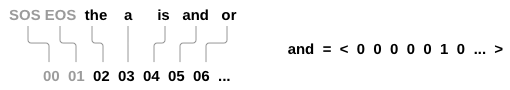

나중에 네트워크의 입력 및 목표로 사용하려면 단어 당 고유 번호가
필요합니다. 이 모든 것을 추적하기 위해 우리는 단어→색인(``word2index``)과 색인→단어(``index2word``) 사전, 그리고 나중에 희귀 단어를 대체하는데 사용할 각 단어의 빈도  ``word2count`` 를 가진 ``Lang`` 이라는 헬퍼 클래스를 사용합니다.


In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


파일은 모두 유니 코드로 되어있어 간단하게하기 위해 유니 코드 문자를 ASCII로 변환하고, 공백을 제거한다.


In [ ]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFC', s)
        if unicodedata.category(c) != 'Mn'
    )

# 공백제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[ ]", r"", s)
    return s

데이터 파일을 읽기 위해 파일을 줄로 분할한 다음 줄을 쌍으로(Tap키) 분할합니다. 파일은 모두 정답 → 오인식 이므로 오인식 → 정답으로 번역하려면 역 플래그를 추가하여 쌍을 반대로 했습니다.

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # pairs = [[s for s in l.split('\t')] for l in lines]
    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

여기서 최대 길이는 100 단어 (종료 문장 부호 포함)이다.

데이터 준비를 위한 전체 과정:

-  텍스트 파일을 읽고 줄로 분리하고, 줄을 쌍으로 분리합니다.
-  텍스트를 정규화 하고 길이와 내용으로 필터링 합니다.
-  쌍을 이룬 문장들로 단어 리스트를 생성합니다.



In [ ]:
MAX_LENGTH = 100

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    # pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('kor', 'copy', True)
print(random.choice(pairs))

#**Seq2Seq 모델**
---
Recurrent Neural Network(RNN)는 시퀀스에서 작동하고 다음 단계의
입력으로 자신의 출력을 사용하는 네트워크입니다.


[Sequence to Sequence network](https://arxiv.org/abs/1409.3215) 또는
Seq2Seq 네트워크, 또는 [Encoder Decodernetwork](https://arxiv.org/pdf/1406.1078v3.pdf) 는 인코더 및 디코더라고 하는 두 개의 RNN으로 구성된 모델입니다. 인코더는 입력 시퀀스를 읽고 단일 벡터를 출력하고, 디코더는 해당 벡터를 읽어 출력 시퀀스를 생성합니다.


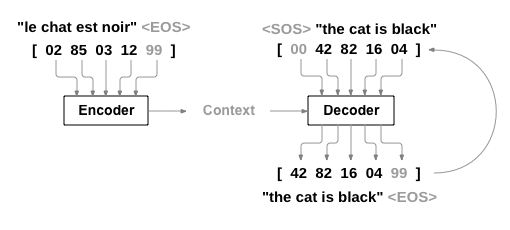


모든 입력에 해당하는 출력이 있는 단일 RNN의 시퀀스 예측과 달리 Seq2Seq 모델은 시퀀스 길이와 순서를 자유롭게하기 때문에 두 언어 사이의 번역에 이상적입니다.


예를들어 다음 문장 "Je ne suis pas le chat noir" → "I am not the black cat"를 살펴 봅시다. 입력 문장의 단어 대부분은 출력 문장에서 직역("chat noir" 와 "black cat")되지만 약간 다른 순서도 있습니다. "ne/pas" 구조로 인해 입력 문장에 단어가 하나 더 있을 수 있습니다. 입력 단어의 시퀀스를 직역해서 정확한 번역을 만드는
것은 어려울 것입니다.


Seq2Seq 모델을 사용하면 인코더는 하나의 벡터를 생성합니다. 이상적인 경우에 입력 시퀀스의 "의미"를 문장의 N 차원 공간에 있는 단일 지점인 단일 벡터로 인코딩합니다.


#**인코더**
---


Seq2Seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을 출력하는 RNN입니다. 모든 입력 단어에 대해 인코더는 벡터와 은닉 상태를 출력하고 다음 입력 단어를 위해 그 은닉 상태를 사용합니다.

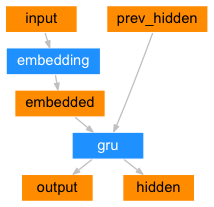

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=1, batch_first=True, bidirectional=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device=device)

#**디코더**
---
디코더는 인코더 출력 벡터를 받아서 번역을 생성하기 위한 단어 시퀀스를 출력합니다.

##**간단한 디코더**

가장 간단한 Seq2Seq 디코더는 인코더의 마지막 출력만을 이용합니다. 이 마지막 출력은 전체 시퀀스에서 문맥을 인코드하기 때문에 *문맥 벡터(context vector)* 로 불립니다. 이 문맥 벡터는 디코더의 초기 은닉 상태로 사용 됩니다.

디코딩의 매 단계에서 디코더에게 입력 토큰과 은닉 상태가 주어집니다. 초기 입력 토큰은 문자열-시작 (start-of-string) ``<SOS>`` 토큰이고, 첫 은닉 상태는 문맥 벡터(인코더의 마지막 은닉 상태) 입니다.

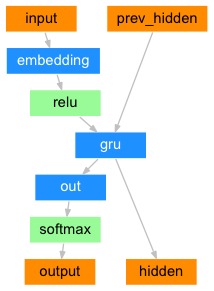

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

이 모델의 결과를 학습하고 관찰하는 것을 권장하지만, 공간을 절약하기 위해 최종 목적지로 바로 이동해서 Attention 메커니즘을 소개 할 것입니다.

#**Attention 디코더**
---
문맥 벡터만 인코더와 디코더 사이로 전달 된다면, 단일 벡터가 전체 문장을 인코딩 해야하는 부담을 가지게 됩니다.

Attention은 디코더 네트워크가 자기 출력의 모든 단계에서 인코더 출력의 다른 부분에 "집중" 할 수 있게 합니다. 첫째 *Attention 가중치* 의 세트를 계산합니다. 이것은 가중치 조합을 만들기 위해서 인코더 출력 벡터와 곱해집니다. 그 결과(코드에서 ``attn_applied``)는 입력 시퀀스의 특정 부분에 관한 정보를 포함해야하고 따라서 디코더가 알맞은 출력 단어를 선택하는 것을 도와줍니다.

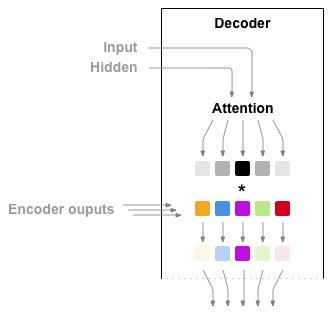

어텐션 가중치 계산은 디코더의 입력 및 은닉 상태를 입력으로 사용하는 다른 feed-forwad 계층인 ``attn`` 으로 수행됩니다. 학습 데이터에는 모든 크기의 문장이 있기 때문에 이 계층을 실제로 만들고 학습시키려면 적용 할 수 있는 최대 문장 길이 (인코더 출력을 위한 입력 길이)를 선택해야 합니다. 최대 길이의 문장은 모든 Attention 가중치를 사용하지만 더 짧은 문장은 처음 몇 개만 사용합니다.

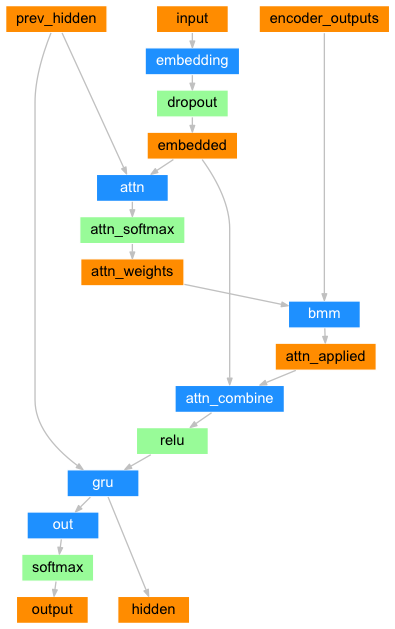



In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.3, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # self.attn = nn.Linear(self.hidden_size * 4, self.max_length)
        self.attn = nn.Linear(self.hidden_size * 3, self.max_length)
        self.attn_combine = nn.Linear((self.hidden_size + self.hidden_size*2), self.hidden_size*2)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size*2, self.hidden_size, num_layers=1,
                          batch_first=True, bidirectional=True)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # temp1 = torch.cat((embedded[0], hidden[0]), 1)
        # temp2 = torch.cat((embedded[0], hidden[1]), 1)
        # attn_weights = F.softmax(self.attn(torch.cat((temp1, temp2), 1)), dim=1)

        temp = torch.cat((hidden[0], hidden[1]), 1)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], temp), 1)), dim=1)

        #bmm => [B, n, m] x [B, m, p] = [B, n, p]
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)

        #unsqueeze(0) => 10의배수 모두 표시하기 어려움 ex)2.0837e-01.... 지수부분인 e뒷부분을 전부 날려서 소숫점 4번째짜리까지만 표기해줌 
        output = self.attn_combine(output).unsqueeze(0)

        #relu = negative number -> positive number
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#**학습**
---

##학습 데이터 준비

학습을 위해서, 각 쌍마다 입력 Tensor(입력 문장의 단어 주소)와
목표 Tensor(목표 문장의 단어 주소)가 필요합니다. 이 벡터들을
생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.


In [ ]:
def indexesFromSentence(lang, sentence):
    idx = []
    for word in sentence:
        try:
            idx.append(lang.word2index[word])
        except KeyError:
            # rand = random.randint(2, MAX_INPUT_LENGTH - 1)
            # idx.append(2)
            print("학습되지 않은 키워드 word = ", word)
    return idx


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#**모델 학습**
------------------

학습을 위해서 인코더에 입력 문장을 넣고 모든 출력과 최신 은닉 상태를 추적합니다. 그런 다음 디코더에 첫 번째 입력으로 ``<SOS>`` 토큰과 인코더의 마지막 은닉 상태가 첫번쩨 은닉 상태로 제공됩니다.

"Teacher forcing"은 다음 입력으로 디코더의 예측을 사용하는 대신 실제 목표 출력을 다음 입력으로 사용하는 컨셉입니다. "Teacher forcing"을 사용하면 수렴이 빨리되지만 [학습된 네트워크가 잘못 사용될 때 불안정성을 보입니다.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf)

Teacher-forced 네트워크의 출력이 일관된 문법으로 읽지만 정확한
번역과는 거리가 멀다는 것을 볼 수 있습니다. 직관적으로 출력 문법을
표현하는 법을 배우고 교사가 처음 몇 단어를 말하면 의미를 "선택" 할 수 있지만,
번역에서 처음으로 문장을 만드는 법은 잘 배우지 못합니다.

PyTorch의 autograd 가 제공하는 자유 덕분에 간단한 If 문으로
Teacher Forcing을 사용할지 아니면 사용하지 않을지를 선택할 수 있습니다.
더 많이 사용하려면 ``teacher_forcing_ratio`` 를 확인하십시오.


In [ ]:
#teacher_forcing_ratio 양수 = True, 음수 = False
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(
        max_length, encoder.hidden_size*2, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


######################################################################
# 이것은 현재 시간과 진행률%을 고려해 경과된 시간과 남은 예상
# 시간을 출력하는 헬퍼 함수입니다.
#

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

전체 학습 과정은 다음과 같습니다:

-  타이머 시작
-  optimizers와 criterion 초기화
-  학습 쌍의 세트 생성
-  도식화를 위한 빈 손실 배열 시작

그런 다음 우리는 여러 번 ``train`` 을 호출하며 때로는 진행률
(예제의 %, 현재까지의 예상 시간)과 평균 손실을 출력합니다.


In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

#**결과 도식화**
----------------

matplotlib로 학습 중에 저장된 손실 값 ``plot_losses`` 의 배열을
사용하여 도식화합니다.


In [ ]:
plt.switch_backend('agg')


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

#**평가**
---

평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의
예측을 되돌려 전달합니다.
단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다.
만약 EOS 토큰을 예측하면 거기에서 멈춥니다.
나중에 도식화를 위해서 디코더의 Attention 출력을 저장합니다.


In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size*2, device=device)

        for ei in range(input_length):
            print("Input_Tensor : ", input_tensor[ei])
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = ['']
        decoder_attentions = torch.zeros(max_length, max_length)

        candidate = [[] for _ in range(5)]

        breakCount = 1
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(6)
            print("Predict_Tensor : ", topi)

            #EOS_token을 만나더라도 sentence size만큼 더 돌아서 후보군의 output(candidate) 개수를 맞춰주고싶은데 어떻게 하지???
            #됐당

            if decoded_words[-1] != '<EOS>':
                if topi[0][0].item() == EOS_token:
                        decoded_words.append('<EOS>')
                else:
                        decoded_words.append(output_lang.index2word[topi[0][0].item()])

            #EOS_token을 만나도 입력문장보다 반복을 적게 했다면 입력문장 길이만큼 더 돌기
            if decoded_words[-1] == '<EOS>':
                if breakCount >= len(sentence):
                    break
                
            for i in range(1, 6):
                if topi[0][i].item() == EOS_token:
                    candidate[i-1].append(' ')
                else:
                    candidate[i-1].append(output_lang.index2word[topi[0][i].item()])

            decoder_input = topi[0][0].squeeze().detach()

            breakCount += 1

        return decoded_words, decoder_attentions[:di + 1], candidate


def evaluate2(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size*2, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

학습 세트에 있는 임의의 문장을 평가하고
입력, 목표 및 출력을 출력하여 주관적인 품질 판단을 내릴 수 있습니다:






In [ ]:
def evaluateRandomly(encoder, decoder, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions, candidate = evaluate(
            encoder, decoder, pair[0])
        
        del output_words[0]

        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

        #예측 후보군(candidate) 5개 재예측
        # for i in range(len(candidate)):
        #     candidate[i] = "".join(candidate[i])
        #     output_words_cand, attentions_cand = evaluate2(encoder, decoder, pair[0])
        #     output_sentence_cand = ' '.join(output_words_cand)
        #     print('Random_후보군 %d번째 =' % (i + 1), candidate[i])
        #     print('Random_후보군 %d번째 예측 =' % (i + 1), output_sentence_cand)
        #     print('')

#**학습과 평가**
---

이러한 모든 헬퍼 함수를 이용해서 (추가 작업처럼 보이지만 여러 실험을
더 쉽게 수행 할 수 있음) 실제로 네트워크를 초기화하고 학습을
시작할 수 있습니다.

입력 문장이 많이 필터링되었음을 기억하십시오. 이 작은 데이터 세트의
경우 256 크기의 은닉 노드(hidden node)와 단일 GRU 계층 같은 상대적으로 작은
네트워크를 사용할 수 있습니다.

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(
    hidden_size, output_lang.n_words, dropout_p=0.3).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=2000)

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

#**Attention 시각화**
---------------------

Attention 메커니즘의 유용한 속성은 하나는 해석 가능성이 높은 출력입니다.
입력 시퀀스의 특정 인코더 출력에 가중치를 부여하는 데 사용되므로
각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있습니다.

Attention 출력을 행렬로 표시하기 위해 ``plt.matshow(attentions)`` 를
간단하게 실행할 수 있습니다. 열은 입력 단계와 행이 출력 단계입니다:


In [ ]:
output_words, attentions = evaluate2(
    encoder1, attn_decoder1, "처울회생법원")
plt.matshow(attentions.numpy())

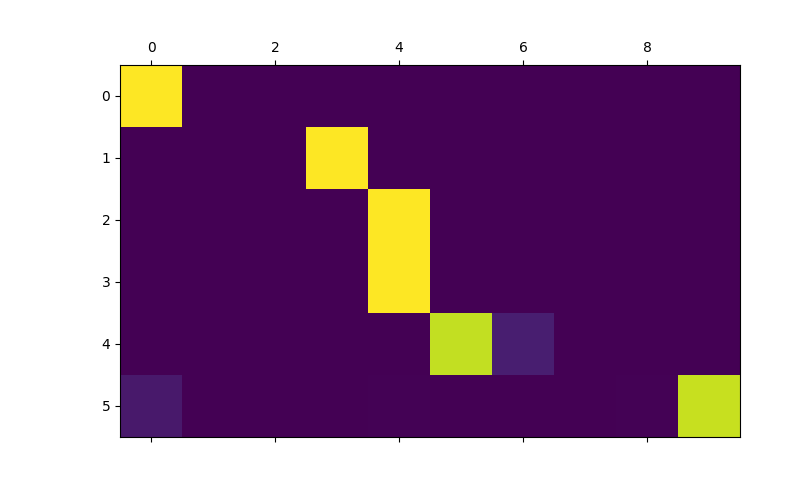

더 나은 보기를 위해 축과 라벨을 더하는 추가 작업을 수행합니다:


In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + list(input_sentence) + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions, candidate = evaluate(
        encoder1, attn_decoder1, input_sentence)

    #첫번째 배열에는 공백이 들어감, 공백제거
    del output_words[0]
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))

    # print('=================후보군=================')
    # for i in range(len(candidate)):
    #     candidate[i] = "".join(candidate[i])
    #     output_words_cand, attentions_cand = evaluate2(
    #         encoder1, attn_decoder1, candidate[i])
    #     print('후보군 %d번째 =' % (i + 1), candidate[i])
    #     print('후보군 예측 =', ' '.join(output_words_cand))
    #     print('')

    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("71드대추")

evaluateAndShowAttention("륵볕기일및장소")

evaluateAndShowAttention("괘인회솅절차를개시한다")

evaluateAndShowAttention("처울회셋빕원")

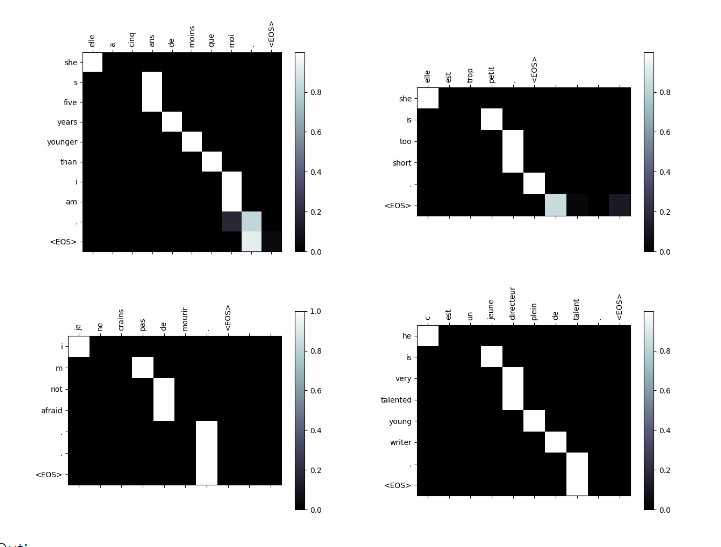
#**연습**
---

-  다른 데이터 셋을 시도해 보십시오

   -  다른 언어쌍
   -  사람 → 기계 (e.g. IOT 명령어)
   -  채팅 → 응답
   -  질문 → 답변

-  word2vec 또는 GloVe 같은 미리 학습된 word embedding 으로
   embedding 을 교체하십시오

-  더 많은 레이어, 은닉 유닛, 더 많은 문장을 사용하십시오.
   학습 시간과 결과를 비교해 보십시오
-  만약 같은 구문 두개의 쌍으로 된 번역 파일을 이용한다면,
   (``I am test \t I am test``), 이것을 오토인코더로
   사용할 수 있습니다.
   이것을 시도해 보십시오:

   -  오토인코더 학습
   -  인코더 네트워크 저장하기
   -  그 상태에서 번역을 위한 새로운 디코더 학습



In [ ]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    print(indexes)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [ ]:
#결과 확인용 print 제거
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size*2, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = ['']
        decoder_attentions = torch.zeros(max_length, max_length)

        candidate = [[] for _ in range(5)]

        breakCount = 0
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(6)

            #EOS_token을 만나더라도 sentence size만큼 더 돌아서 후보군의 output(candidate) 개수를 맞춰주고싶은데 어떻게 하지???
            #됐당

            if decoded_words[-1] != '<EOS>':
                if topi[0][0].item() == EOS_token:
                        decoded_words.append('<EOS>')
                else:
                        decoded_words.append(output_lang.index2word[topi[0][0].item()])

            #EOS_token을 만나도 입력문장보다 반복을 적게 했다면 입력문장 길이만큼 더 돌기
            if decoded_words[-1] == '<EOS>':
                if breakCount >= len(sentence):
                    break

            for i in range(1, 6):
                if topi[0][i].item() == EOS_token:
                    candidate[i-1].append(' ')
                else:
                    candidate[i-1].append(output_lang.index2word[topi[0][i].item()])

            decoder_input = topi[0][0].squeeze().detach()

            breakCount += 1
        return decoded_words, decoder_attentions[:di + 1], candidate

#후보군 제거
def evaluateAndShowAttention(input_sentence):
    output_words, attentions, candidate = evaluate(
        encoder1, attn_decoder1, input_sentence)
    
    del output_words[0]
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))

    # print('=================후보군 5개=================')
    # for i in range(len(candidate)):
    #     candidate[i] = "".join(candidate[i])
    #     output_words_cand, attentions_cand = evaluate2(encoder1, attn_decoder1, candidate[i])
    #     print('후보군 %d번째 ='%(i + 1), candidate[i])
    #     print('후보군 예측 =', ' '.join(output_words_cand))
    #     print('')
    # showAttention(input_sentence, output_words, attentions)

# **Test (2022-07-20)**
---
> - 단어쌍 : 1269개
> - 단어 종류 : 77개
> - 정답 낱자 개수 : 120개
> - 오인식 낱자 개수 : 283개
> - Teacher Forcing 포함 : 목표를 다음 입력으로 전달
> - Hidden Size : 256
> - n_iters : 75000
> - Loss (GPU 사용 x, 사용시 30분이내)
>  - 73m 52s (- 21m 39s) (58000 77%) 0.0016
>  - 76m 30s (- 19m 7s) (60000 80%) 0.0025
>  - 79m 2s (- 16m 34s) (62000 82%) 0.0012
>  - 81m 33s (- 14m 1s) (64000 85%) 0.0015
>  - 84m 2s (- 11m 27s) (66000 88%) 0.0022
>  - 86m 34s (- 8m 54s) (68000 90%) 0.0013
>  - 89m 2s (- 6m 21s) (70000 93%) 0.0016
>  - 91m 34s (- 3m 48s) (72000 96%) 0.0007
>  - 94m 4s (- 1m 16s) (74000 98%) 0.0010

In [ ]:
evaluateAndShowAttention("지방빕원")

input = 지방빕원
output = 지 방 법 원 <EOS>


In [ ]:
evaluateAndShowAttention("71드대춤")

input = 71드대춤
output = 카 드 대 출 <EOS>


In [ ]:
evaluateAndShowAttention("의견청취71이")

input = 의견청취71이
output = 의 견 청 취 기 일 <EOS>


In [ ]:
evaluateAndShowAttention("01의신청7간")

input = 01의신청7간
output = 이 의 신 청 기 간 <EOS>


In [ ]:
evaluateAndShowAttention("71드대출")

input = 71드대출
output = 카 드 대 출 <EOS>


In [ ]:
evaluateAndShowAttention("게인회셋채권자목로")

input = 게인회셋채권자목로
output = 개 인 회 생 채 권 자 목 록 <EOS>


In [ ]:
evaluateAndShowAttention("7H인회생")

학습되지 않은 키워드 word =  H
input = 7H인회생
output = 개 인 회 생 <EOS>


In [ ]:
evaluateAndShowAttention("우리규드")

input = 우리규드
output = 우 리 카 드 <EOS>


In [ ]:
evaluateAndShowAttention("자건처리혹구서")

input = 자건처리혹구서
output = 사 건 처 리 촉 구 서 <EOS>


In [ ]:
evaluateAndShowAttention("인천기방빕원")

input = 인천기방빕원
output = 인 천 지 방 법 원 <EOS>


In [ ]:
evaluateAndShowAttention("물사기방법원")

input = 물사기방법원
output = 울 산 지 방 법 원 <EOS>


In [ ]:
evaluateAndShowAttention("인천지바냅원")

input = 인천지바냅원
output = 인 천 지 방 법 원 <EOS>


In [ ]:
evaluateAndShowAttention("7H인회생절차 개시결정을 하였으므로")

학습되지 않은 키워드 word =  H
학습되지 않은 키워드 word =   
학습되지 않은 키워드 word =   
input = 7H인회생절차 개시결정을 하였으므로
output = 개 인 회 생 절 차 개 시 결 정 을 하 였 으 므 로 <EOS>


In [ ]:
evaluateAndShowAttention("대구기방빕운")

input = 대구기방빕운
output = 대 구 지 방 법 원 <EOS>


In [ ]:
evaluateAndShowAttention("7용초득에의하빈줴")

학습되지 않은 키워드 word =  줴
input = 7용초득에의하빈줴
output = 가 용 소 득 에 의 한 변 제 <EOS>


In [ ]:
evaluateAndShowAttention("쯴변제뎨정신정내역")

input = 쯴변제뎨정신정내역
output = 총 변 제 예 정 산 정 내 역 <EOS>


In [ ]:
evaluateAndShowAttention("슈정된gain회샛채굳자꼭톡")

학습되지 않은 키워드 word =  슈
학습되지 않은 키워드 word =  g
학습되지 않은 키워드 word =  a
학습되지 않은 키워드 word =  n
input = 슈정된gain회샛채굳자꼭톡
output = 수 정 된 개 인 회 생 채 권 자 목 록 <EOS>


In [ ]:
evaluateAndShowAttention("구정묀사창에관한")

input = 구정묀사창에관한
output = 수 정 된 사 항 에 관 한 <EOS>


In [ ]:
evaluateAndShowAttention("닌7ㅏ의개상이됨늬다")

학습되지 않은 키워드 word =  됨
학습되지 않은 키워드 word =  늬
input = 닌7ㅏ의개상이됨늬다
output = 인 가 의 대 상 이 됩 니 다 <EOS>


In [ ]:
evaluateAndShowAttention("체묻자")

학습되지 않은 키워드 word =  묻
input = 체묻자
output = 채 무 자 <EOS>


In [ ]:
evaluateAndShowAttention("괴인회생절치를게人한다")

input = 괴인회생절치를게人한다
output = 개 인 회 생 절 차 를 개 시 한 다 <EOS>


In [ ]:
evaluateAndShowAttention("쯴변제뎨정신정내역")

input = 쯴변제뎨정신정내역
output = 총 변 제 예 정 산 정 내 역 <EOS>
